In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load sales summary
sales_df = pd.read_csv(r"D:\Project\glp1_ci_project_2020_2025\data\processed\sales_summary.csv")

# Make sure numeric
for col in sales_df.columns[1:]:
    sales_df[col] = pd.to_numeric(sales_df[col], errors="coerce").fillna(0)

sales_df


,year,ozempic_dkk_mn,rybelsus_dkk_mn,wegovy_dkk_mn,mounjaro_usd_mn,zepbound_usd_mn
0,2020,21211,1873,0,0,0
1,2021,33705,4838,0,0,0
2,2022,59750,11299,0,482,0
3,2023,95703,0,0,0,0
4,2024,0,0,0,0,0


In [2]:
def make_cagr_forecast(df, product_col, start_year=None, end_year=None,
                       forecast_start=2025, forecast_end=2030):
    """
    df: sales_df
    product_col: e.g. 'ozempic_dkk_mn'
    start_year/end_year: which years to use for CAGR (if None -> first & last non-zero)
    """

    series = df[["year", product_col]].copy()
    # filter non-zero years only
    series = series[series[product_col] > 0]

    if start_year is None:
        start_year = int(series["year"].min())
    if end_year is None:
        end_year = int(series["year"].max())

    base = series[series["year"] == start_year][product_col].values[0]
    last = series[series["year"] == end_year][product_col].values[0]

    n_years = end_year - start_year
    if n_years <= 0 or base <= 0:
        raise ValueError("Not enough data to compute CAGR")

    cagr = (last / base) ** (1 / n_years) - 1

    print(f"{product_col}: using {start_year}-{end_year}, base={base}, last={last}, CAGR={cagr*100:.1f}%")

    # build forecast dataframe
    future_years = list(range(forecast_start, forecast_end + 1))
    future_values = []
    for y in future_years:
        t = y - end_year
        fv = last * ((1 + cagr) ** t)
        future_values.append(fv)

    forecast_df = pd.DataFrame({
        "year": future_years,
        product_col: future_values
    })

    return cagr, forecast_df


In [3]:
# Ozempic forecast: use 2020–2023 as history (2024 is placeholder 0, so we ignore it)
cagr_oz, oz_future = make_cagr_forecast(
    sales_df,
    product_col="ozempic_dkk_mn",
    start_year=2020,
    end_year=2023,
    forecast_start=2025,
    forecast_end=2030
)

oz_future


ozempic_dkk_mn: using 2020-2023, base=21211, last=95703, CAGR=65.2%


,year,ozempic_dkk_mn
0,2025,2.613175e+05
1,2026,4.318073e+05
2,2027,7.135287e+05
3,2028,1.179052e+06
4,2029,1.948293e+06
5,2030,3.219407e+06


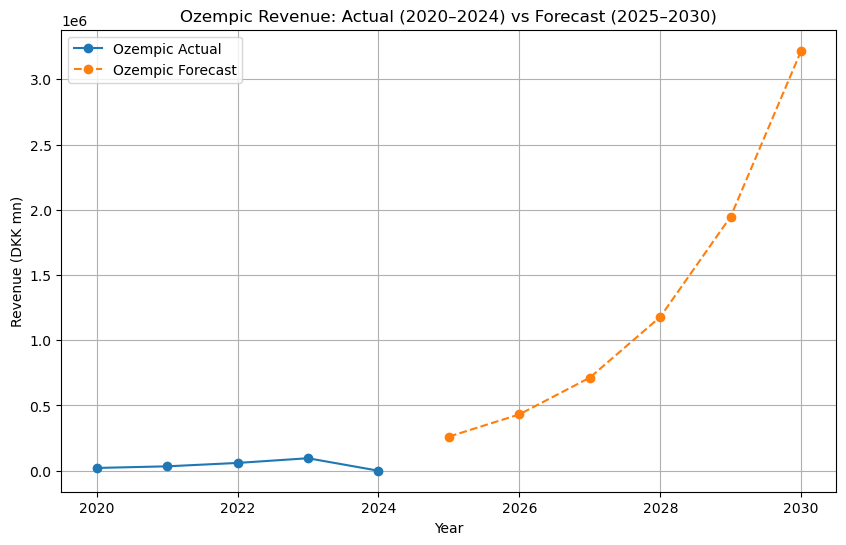

In [4]:
# Combine history + forecast
oz_hist = sales_df[["year", "ozempic_dkk_mn"]].copy()
oz_hist["type"] = "Actual"

oz_future_plot = oz_future.copy()
oz_future_plot["type"] = "Forecast"

oz_combined = pd.concat([oz_hist, oz_future_plot], ignore_index=True)

# Plot
plt.figure(figsize=(10,6))

actual = oz_combined[oz_combined["type"] == "Actual"]
forecast = oz_combined[oz_combined["type"] == "Forecast"]

plt.plot(actual["year"], actual["ozempic_dkk_mn"], marker="o", label="Ozempic Actual")
plt.plot(forecast["year"], forecast["ozempic_dkk_mn"], marker="o", linestyle="--", label="Ozempic Forecast")

plt.title("Ozempic Revenue: Actual (2020–2024) vs Forecast (2025–2030)")
plt.xlabel("Year")
plt.ylabel("Revenue (DKK mn)")
plt.grid(True)
plt.legend()
plt.show()


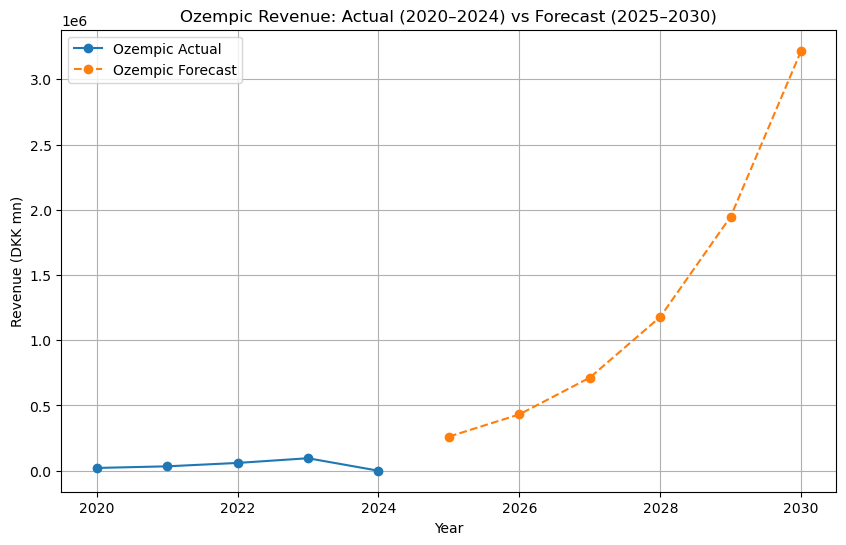

'D:\\Project\\glp1_ci_project_2020_2025\\reports\\figures\\ozempic_actual_vs_forecast_2020_2030.png'

In [5]:
import os
import matplotlib.pyplot as plt

fig_dir = r"D:\Project\glp1_ci_project_2020_2025\reports\figures"
os.makedirs(fig_dir, exist_ok=True)

# Re-plot and save
oz_hist = sales_df[["year", "ozempic_dkk_mn"]].copy()
oz_hist["type"] = "Actual"

oz_future_plot = oz_future.copy()
oz_future_plot["type"] = "Forecast"

oz_combined = pd.concat([oz_hist, oz_future_plot], ignore_index=True)

plt.figure(figsize=(10,6))

actual = oz_combined[oz_combined["type"] == "Actual"]
forecast = oz_combined[oz_combined["type"] == "Forecast"]

plt.plot(actual["year"], actual["ozempic_dkk_mn"], marker="o", label="Ozempic Actual")
plt.plot(forecast["year"], forecast["ozempic_dkk_mn"], marker="o", linestyle="--", label="Ozempic Forecast")

plt.title("Ozempic Revenue: Actual (2020–2024) vs Forecast (2025–2030)")
plt.xlabel("Year")
plt.ylabel("Revenue (DKK mn)")
plt.grid(True)
plt.legend()

out_path = os.path.join(fig_dir, "ozempic_actual_vs_forecast_2020_2030.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

out_path
